### Imports and Setup

Loads all libraries needed for vectorization, SVM, tuning and evaluation 

In [15]:
import pandas as pd 
import numpy as np 
import re 
import string 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import(
    classification_report, 
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords 

nltk.download("stopwords")

pd.set_option("display.max_colwidth", 300)
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\himu7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Dataset

Loads the same dataset explored in EDA.

This guarantess:
* No hidden data differences
* No pipleline mismatch

In [16]:
df = pd.read_csv("../data/combined_news.csv")

print(df.shape)
df.head(2)

(44898, 10)


,title,text,subject,date,label,text_length,title_length,date_parsed,year_month,content
0,"BREAKING: GOP Chairman Grassley Has Had Enough, DEMANDS Trump Jr. Testimony","Donald Trump s White House is in chaos, and they are trying to cover it up. Their Russia problems are mounting by the hour, and they refuse to acknowledge that there are problems surrounding all of this. To them, it s fake news, or a hoax. However, the facts bear things out differently, and ...",News,"July 21, 2017",0,2114,76,2017-07-21,2017-07,"BREAKING: GOP Chairman Grassley Has Had Enough, DEMANDS Trump Jr. Testimony Donald Trump s White House is in chaos, and they are trying to cover it up. Their Russia problems are mounting by the hour, and they refuse to acknowledge that there are problems surrounding all of this. To them, it s ..."
1,Failed GOP Candidates Remembered In Hilarious Mocking Eulogies (VIDEO),"Now that Donald Trump is the presumptive GOP nominee, it s time to remember all those other candidates who tried so hard to beat him in the race to the White House. After all, how can we forget all the missteps, gaffes, weirdness, and sheer idiocies of such candidates as Jeb Bush, Marco Rubio, J...",News,"May 7, 2016",0,2823,71,2016-05-07,2016-05,"Failed GOP Candidates Remembered In Hilarious Mocking Eulogies (VIDEO) Now that Donald Trump is the presumptive GOP nominee, it s time to remember all those other candidates who tried so hard to beat him in the race to the White House. After all, how can we forget all the missteps, gaffes, weir..."


### Use Choosen Preprocessing

Implements winning preprocessing:
  * No stopwords + punctuation removed

This matches what empirically discovered earlier.

In [17]:
stop_words = set(stopwords.words("english"))

def clean_no_stopwords(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"<.*>", "", text)
    text = text.translate(str.maketrans("","", string.punctuation))
    words = text.split()
    return " ".join([ w for w in words if w not in stop_words])

### Train/Test Split

Freezes the train/test split:

This is critical:
* Hyperparameter tuning must NEVER see test data.

In [18]:
from sklearn.model_selection import train_test_split

X=df['content']
y=df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train: ", X_train.shape)
print("Test: ", X_test.shape)

Train:  (35918,)
Test:  (8980,)


### Build Pipeline (Preprocessing + TF-IDF + Model)
Builds a Pipeline that ensures:
> Whatever happens in training happens exactly the same in testing.

No leakage. No mismatches.

In [23]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=clean_no_stopwords,
        ngram_range=(1,2),
        min_df=5,
        max_df=0.95,
        sublinear_tf=True
    )),
    ("svm", LinearSVC())
])

### Hyperparameter Grid
Defines what are tuning:
SVM's C(regularization strength)

This controls:
* Overfitting vs generalization 

In [24]:
param_grid = {
    "svm__C": [0.01,0.1,1,10]
}

### Cross Validation Hyperparameter Search
Runs 5 fold cross-validation on the training set.

This prevents
* Lucky splits
* Overfitting to one fold

In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline, 
    param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=1,
    verbose=2
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ........................................svm__C=0.01; total time=  21.6s
[CV] END ........................................svm__C=0.01; total time=  23.9s
[CV] END ........................................svm__C=0.01; total time=  31.3s
[CV] END ........................................svm__C=0.01; total time=  31.0s
[CV] END ........................................svm__C=0.01; total time=  32.6s
[CV] END .........................................svm__C=0.1; total time=  21.9s
[CV] END .........................................svm__C=0.1; total time=  21.7s
[CV] END .........................................svm__C=0.1; total time=  22.2s
[CV] END .........................................svm__C=0.1; total time=  22.0s
[CV] END .........................................svm__C=0.1; total time=  22.4s
[CV] END ...........................................svm__C=1; total time=  23.3s
[CV] END ........................................

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...LinearSVC())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'svm__C': [0.01, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : t

### Best Model

Select the best C based on average F1 across folds.

This is true model selection step.

In [27]:
print("Best C: ", grid.best_params_["svm__C"])
print("Best CV F1: ", grid.best_score_)

Best C:  10
Best CV F1:  0.9975507651880621


### Final Evaluation on Unseen test set

Evaluates the tuned model on unseen test data. 

This is the onlhy number you should report.

In [28]:
best_model = grid.best_estimator_

test_preds = best_model.predict(X_test)

print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



### Confusion Matrix

Shows how errors are distribured:
* Fake : Real?
* Real : Fake?

This tells what model is afriad of.

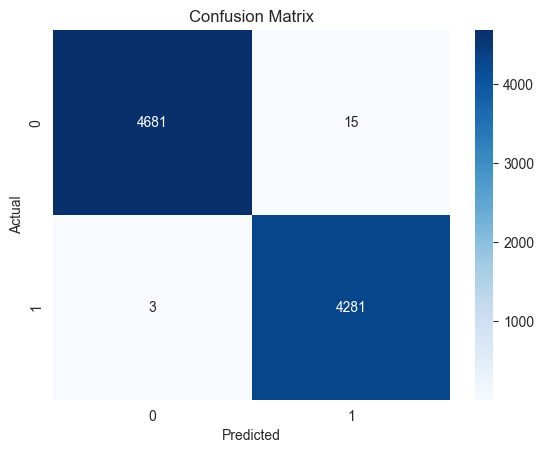

In [31]:
cm = confusion_matrix(y_test, test_preds)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Error Analysis

Read actual misclassified articles.

This is where:

* Dataset bias
* Ambiguity
* Label noise become visible.

In [30]:
test_results = X_test.to_frame()
test_results["true_label"] = y_test.values
test_results["predicted_label"] = test_preds


false_positive = test_results[
    (test_results["true_label"] == 1) & (test_results["predicted_label"]==0)
]

false_negative = test_results[
    (test_results["true_label"]==0) & (test_results["predicted_label"]==1)
]

print("False Positives: ", len(false_positive))
print("False Negatives: ", len(false_negative))

false_positive.head(2)

False Positives:  3
False Negatives:  15


,content,true_label,predicted_label
20143,"Text of Michael Flynn's letter resigning as national security adviser WASHINGTON (Reuters) - National security adviser Michael Flynn became the first high-profile member of President Donald Trump’s administration to resign, leaving the job late on Monday amid controversy over discussions he had ...",1,0
14098,"Commentary: Manic or evasive - these veep guys sure don’t feel like leaders After going through a week reminiscent of Napoleon’s at Waterloo, Republican presidential nominee Donald Trump will likely claim that Indiana Governor Mike Pence’s performance in Tuesday’s vice-presidential debate gave a...",1,0


### Save Final Model

Saves a fully reproducible model.

We can now:
* Deploy 
* Load it 
* Use it for prediction

In [32]:
import joblib 

joblib.dump(best_model, "../models/best_model.pkl")

print("Final model saved to models/best_model.pkl")

Final model saved to models/best_model.pkl
